In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler ,  MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
df = pd.read_csv("Bank_Transaction_Fraud_Detection.csv")
df.drop(['Customer_ID' , 'Customer_Name' , 'Transaction_ID' , 'Customer_Email' , 'Customer_Contact' , 'Merchant_ID' , 'Transaction_Currency'] , axis = 1 , inplace = True)
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])
df['Transaction_year'] = df['Transaction_Date'].dt.year
df['Transaction_month'] = df['Transaction_Date'].dt.month_name()
df['Transaction_day'] = df['Transaction_Date'].dt.day_name()
df['Transaction_Time'] = pd.to_datetime(df['Transaction_Time'])

def categorize_time(time):
    hour = time.hour
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['Transaction_Time'] = df['Transaction_Time'].apply(categorize_time)
def categorize_age(Age):
   if 18 <= Age < 40:
        return 'Young Adult'
   elif 40 <= Age < 60:
        return 'Middle-Aged'
   else:
        return 'Senior'

df['Age_Category'] = df['Age'].apply(categorize_age)
df['Transaction_Amount (INR)'] = df['Transaction_Amount']
df.drop(['Transaction_Date','Transaction_Amount','Transaction_month']  , axis = 1 , inplace = True)
num_cols = df.select_dtypes(include=[np.number, 'datetime']).columns
cat_cols = df.select_dtypes(exclude=[np.number, 'datetime']).columns
df.drop('Age', axis=1, inplace=True)
label_cols = ['Gender','State', 'City', 'Bank_Branch', 'Account_Type',
       'Transaction_Time', 'Transaction_Type', 'Merchant_Category',
       'Transaction_Device', 'Transaction_Location', 'Device_Type',
       'Transaction_Description', 'Transaction_day', 'Age_Category']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import VarianceThreshold
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, average_precision_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load Data (Assuming df is preloaded with 'Is_Fraud' column)
X = df.drop(columns=['Is_Fraud'])
y = df['Is_Fraud']

# ===========================
# Step 1: Normalize Data
# ===========================
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ===========================
# Step 2: Autoencoder for Anomaly Detection
# ===========================

input_dim = X.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

# Train Autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=128, shuffle=True, validation_split=0.2, verbose=1)

# Compute Reconstruction Error
X_reconstructed = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.abs(X_scaled - X_reconstructed), axis=1)
df['Reconstruction_Error'] = (reconstruction_error - np.min(reconstruction_error)) / (np.max(reconstruction_error) - np.min(reconstruction_error))
X['Reconstruction_Error'] = df['Reconstruction_Error']

# ===========================
# Step 3: Anomaly Detection (Isolation Forest & LOF)
# ===========================
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['Anomaly_Score'] = iso_forest.fit_predict(X_scaled)
df['Anomaly_Score'] = df['Anomaly_Score'].apply(lambda x: 1 if x == -1 else 0)
X['Anomaly_Score'] = df['Anomaly_Score']

#lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
#df['LOF_Anomaly_Score'] = lof.fit_predict(X_scaled)
#df['LOF_Anomaly_Score'] = df['LOF_Anomaly_Score'].apply(lambda x: 1 if x == -1 else 0)
#X['LOF_Anomaly_Score'] = df['LOF_Anomaly_Score']

# ===========================
# Step 4: Dimensionality Reduction
# ===========================
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X.drop(columns=['Reconstruction_Error', 'Anomaly_Score']))

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_selected)

# Add anomaly-related features back
anomaly_features = df[['Reconstruction_Error', 'Anomaly_Score']].values
X_final = np.column_stack((X_pca, anomaly_features))
print(f"Number of components selected: {pca.n_components_}")
print(f"Number of components selected: {pca.n_components_}")
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Explained variance by components: {explained_variance}")
# ===========================
# Step 5: Balance Data (SMOTEENN)
# ===========================
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_final, y)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# ===========================
# Step 6: Train XGBoost Model
# ===========================
xgb_model = XGBClassifier(n_estimators=300, max_depth=15, learning_rate=0.05, colsample_bytree=0.8, subsample=0.8, random_state=42)
xgb_model.fit(X_train, y_train)

# Model Evaluation
y_pred = xgb_model.predict(X_test)

print("\nXGBoost Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision-Recall AUC: {average_precision_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred))

Epoch 1/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0644 - val_loss: 0.0178
Epoch 2/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 3/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 4/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 5/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 6/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 7/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 8/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 9/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 10/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 11/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 12/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

In [ ]:
print(f"Number of components selected: {pca.n_components_}")
print(f"Number of components selected: {pca.n_components_}")
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Explained variance by components: {explained_variance}")

Number of components selected: 10
Number of components selected: 10
Explained variance by components: [0.5197818  0.99999492 0.99999833 0.99999991 0.99999997 0.99999999
 0.99999999 1.         1.         1.        ]



XGBoost Model Performance Metrics:
Accuracy: 0.963
Precision: 1.000
Recall: 0.934
F1 Score: 0.966
ROC AUC Score: 0.967

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      9213
           1       1.00      0.93      0.97     11369

    accuracy                           0.96     20582
   macro avg       0.96      0.97      0.96     20582
weighted avg       0.97      0.96      0.96     20582



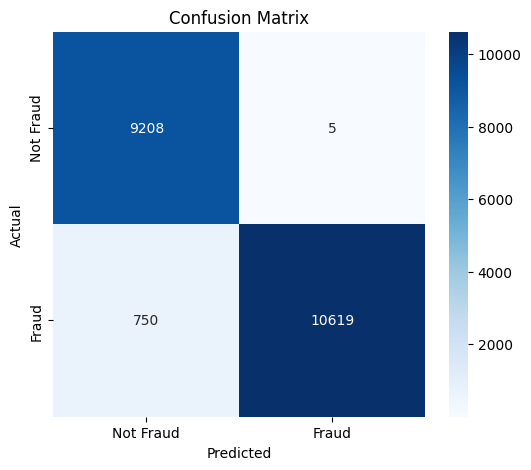

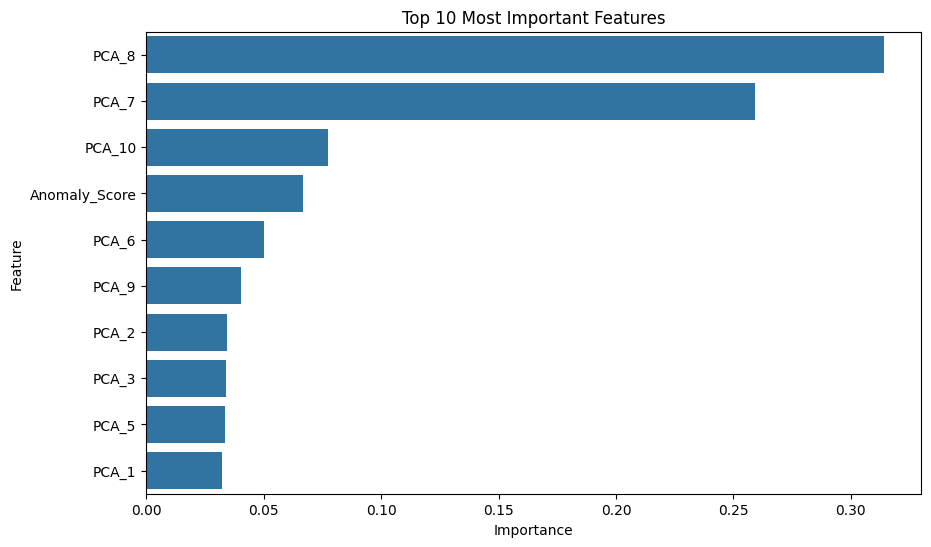

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print Metrics
print("\nXGBoost Model Performance Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC Score: {roc_auc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ===========================
# Feature Importance Plot
# ===========================

# Generate feature names (PCA features + Anomaly features)
pca_feature_names = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]
anomaly_feature_names = ['Reconstruction_Error', 'Anomaly_Score']
feature_names = pca_feature_names + anomaly_feature_names

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Top 10 Important Features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.show()


Top 10 Most Important Features:
          Feature  Importance
7           PCA_8    0.314201
6           PCA_7    0.259171
9          PCA_10    0.077525
11  Anomaly_Score    0.066739
5           PCA_6    0.050227
8           PCA_9    0.040541
1           PCA_2    0.034296
2           PCA_3    0.034128
4           PCA_5    0.033736
0           PCA_1    0.032186


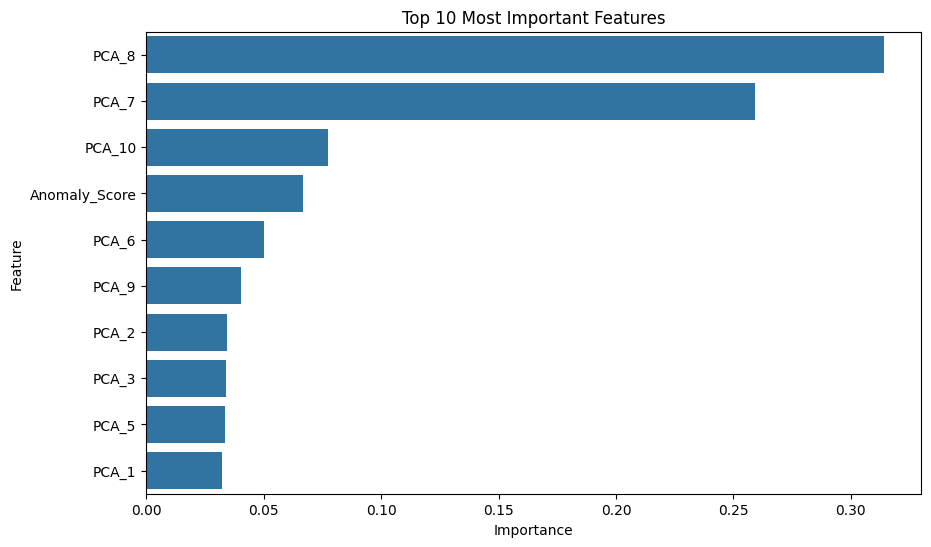

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create feature names for PCA components
pca_feature_names = [f'PCA_{i+1}' for i in range(pca.n_components_)]
anomaly_feature_names = ['Reconstruction_Error', 'Anomaly_Score']
all_feature_names = pca_feature_names + anomaly_feature_names

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.show()


In [ ]:
import pickle

# Store all models in a dictionary
hybrid_model = {
    'scaler': scaler,
    'autoencoder': autoencoder,
    'isolation_forest': iso_forest,
    #'lof': lof,
    'pca': pca,
    'xgb': xgb_model
}

# Save to a pickle file
with open('hybrid_fraud_model.pkl', 'wb') as f:
    pickle.dump(hybrid_model, f)

print("Hybrid model saved successfully!")

Hybrid model saved successfully!
